# Torrence and Compo 1998
## [sst_nino3.data example](https://github.com/PyWavelets/pywt/blob/master/demo/cwt_analysis.py)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd
import math

import pywt

In [58]:
# Download nino data
time, sst_data = pywt.data.nino()

sst_df = pd.DataFrame({'time (years)': time, 'temperature (C)': sst_data})
sst_df.head()

,time (years),temperature (C)
0,1950.00,-0.654498
1,1950.25,0.139786
2,1950.50,-1.161550
3,1950.75,-1.372577
4,1951.00,0.043065


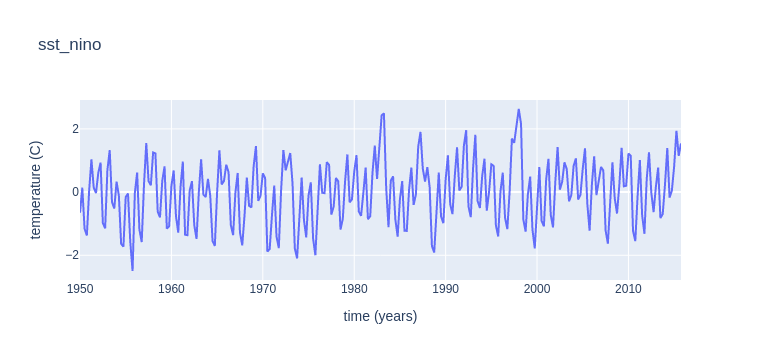

In [59]:
# Plot data
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

fig = px.line(data_frame=sst_df, x="time (years)", y="temperature (C)",
              title="sst_nino")
fig.show()

size (28, 264) with 28 scales and 264 time steps
x-axis (time) be default is: 264
y-axis (scale) be default is: 28


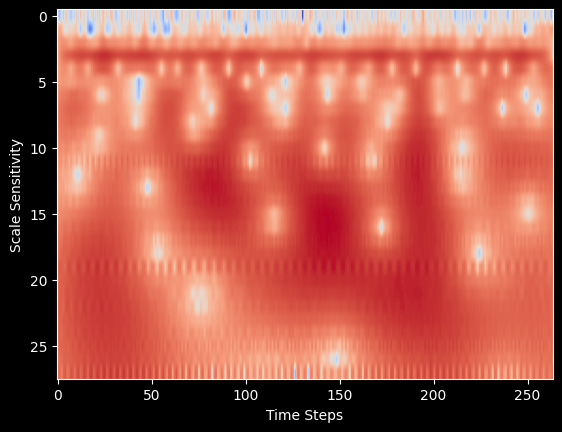

In [78]:
wavelet_mother = "cmor1.5-1.0" # Morlet in Torrence/Compo cooresponds to cmor in PyWavelets -> https://github.com/PyWavelets/pywt/issues/522#issuecomment-539227912

dt = 0.25 # sampling period (time between each y-value)
n = len(sst_data)
s0 = 2*dt # smallest scale
dj = 0.25 # spaceing between discrete scales (default to 0.25)
j_size = int(np.fix((np.log(n * dt / s0) / np.log(2)) / dj)) # number of scales
scales = np.arange(1, j_size+1)
#print(scales)
#scales = np.arange(1, 27+1)
#print(scales)
wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=wavelet_mother,
                                 sampling_period=dt)

# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis (time) be default is: {wavelet_coeffs.shape[1]}")
print(f"y-axis (scale) be default is: {wavelet_coeffs.shape[0]}")


# Plot scalogram
plt.style.use('dark_background')
data = np.log2(abs(wavelet_coeffs)) # compare the magntiude
plt.xlabel("Time Steps")
plt.ylabel("Scale Sensitivity")
plt.imshow(data, 
           vmax=(data).max(), vmin=(data).min(),
           cmap="coolwarm", aspect="auto")
plt.show()

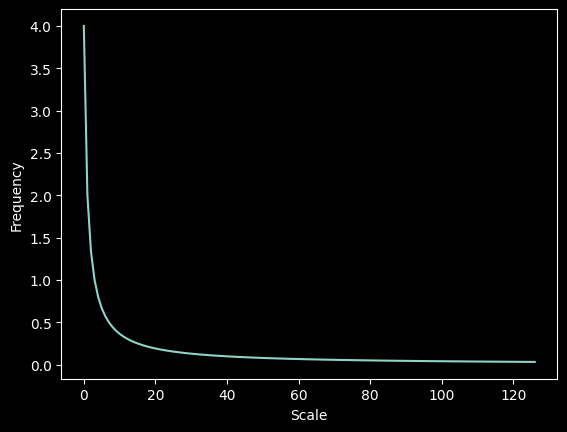

In [35]:
# Useful to determine the right range of scales
plt.style.use('dark_background')
plt.xlabel("Scale")
plt.ylabel("Frequency")
plt.plot(freqs)

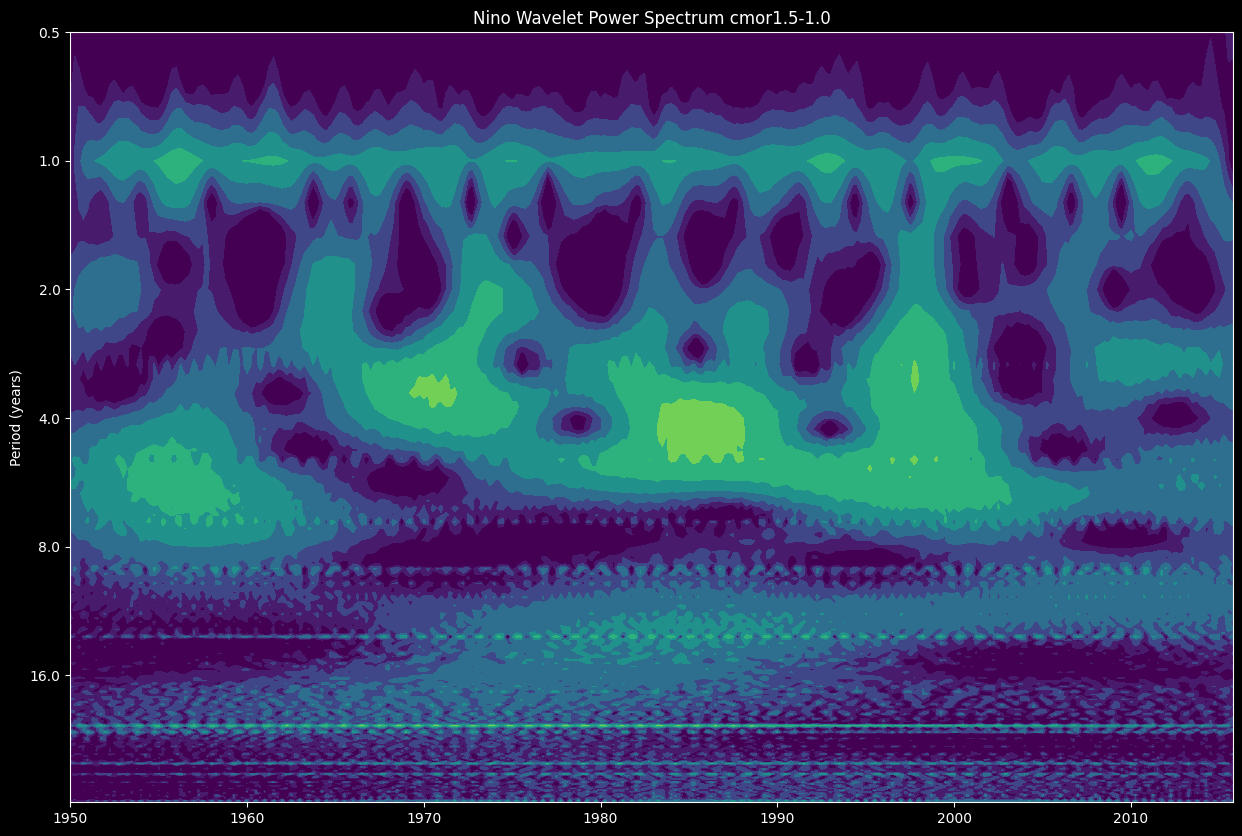

In [36]:
power = np.power((abs(wavelet_coeffs)), 2)
period = 1/freqs
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
f, ax = plt.subplots(figsize=(15, 10))
ax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
            extend='both')

ax.set_title(f"Nino Wavelet Power Spectrum {wavelet_mother}")
ax.set_ylabel("Period (years)")
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                        np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(Yticks))
ax.set_yticklabels(Yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)

plt.show()